In [2]:
from simple_pid import PID
from database_def import Record

In [ ]:
pid = PID(1, 0.1, 0.05, setpoint=1)

# assume we have a system we want to control in controlled_system
v = controlled_system.update(0)

r = Record()

while True:
    # compute new ouput from the PID according to the systems current value
    control = pid(v)

    # feed the PID output to the system and get its current value
    v = controlled_system.update(control)

In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [123]:
class Record:
    """
    Holds values of state of pendulum
    example initiation:

    record = Record(previous_record, M_1=11.2, L=280)

    , where previous_record is of instance Record
    """
    def __init__(self, *args, **kwargs):
        if args:
            if isinstance(args[0], Record):
                self.record = args[0].record.copy()
                self.record.name = self.new_record().name
        else:
            self.record = self.new_record()

        for key, value in kwargs.items():
            self.record[key] = value
        
        self.stack_of_movement = self.new_movement_record()
        self.last_movement = self.new_movement_record()

        self.stack_of_movement.name = "stack_of_movement"

    def __str__(self):
        return ''.join((self.record.to_string(),('\n\n'),
                        self.last_movement.to_string(),('\n\n'),
                        self.stack_of_movement.to_string()))

    @staticmethod
    def new_record():
        record = pd.DataFrame(columns=['m_1', 'm_2', 'l',
                                     '__x', '_x', 'x',
                                     '__fi', '_fi', 'fi',
                                     'g', 't'],
                              index=[0],
                              dtype=np.float32)
        record.name = "record"
        return record

    @staticmethod
    def new_movement_record():
        movement_record = pd.DataFrame(columns=['__x', '_x', 'x',
                                                '__fi', '_fi', 'fi',
                                                't'],
                                       index=[1],
                                       dtype=np.float32)
        movement_record.name = "last_movement"
        return movement_record

    def give_movement_param(self):
        column_names = self.new_movement_record().columns
        return self.record[column_names]

    def give_angle(self):
        """ Operates with degrees"""
        return self.record['Fi_2']/np.pi*180

    def change_angle(self, angle_value):
        """ Operates with degrees"""
        self.record['Fi_2'] = np.pi*angle_value/180

    def dummy_set(self):
        for key in self.record.columns:
            self.record[key] = np.random.random()

    def position_set(self, angle_in_degrees):
        input_table = [20, 2, 1, 
                       0, 0, 0,
                       0, 0, angle_in_degrees*np.pi/180.0,
                       9.81, 0]
        for pos, key in enumerate(self.record.columns):
            self.record[key] = input_table[pos]

    @staticmethod
    def sort_time(source):
        for row in source.index[:-1]:
            if source.loc[row+1, 't'] < source.loc[row, 't']:
                source.loc[row + 1:, 't'] += source.loc[row, 't']
                break

    def update_stacks(self):
        self.stack_of_movement.dropna(inplace=True)
        stack_name = self.stack_of_movement.name
        self.stack_of_movement = self.stack_of_movement.append(self.last_movement,
                                                               ignore_index=True)
        self.stack_of_movement.drop_duplicates(inplace=True, keep='first')
        self.stack_of_movement.name = stack_name
        self.sort_time(self.stack_of_movement)

        self.last_movement = self.new_movement_record()
        self.update_last_movement()

    def update_last_movement(self):
        movement_name = self.last_movement.name
        self.last_movement.dropna(inplace=True)
        self.last_movement = self.last_movement.append(self.give_movement_param(),
                                                       ignore_index=True)
        self.last_movement.drop_duplicates(inplace=True, keep='first')
        self.last_movement.name = movement_name

    def single_move(self, force_table_record):
        self.update_last_movement()
        force, dt = force_table_record

        """ movement equations"""
        self.record['__x'] = (- np.multiply.reduce([self.record['m_2'],
                                                   self.record['l'],
                                                   np.power(self.record['_fi'], 2),
                                                   np.sin(self.record['fi'])])
                             + np.multiply.reduce([self.record['m_2'],
                                                   self.record['l'],
                                                   self.record['__fi'],
                                                   np.cos(self.record['fi'])])
                             - force
                             ) / np.add(self.record['m_1'],
                                        self.record['m_2'])

        self.record['__fi'] = (+ np.multiply.reduce([self.record['g'],
                                                   np.sin(self.record['fi'])])
                             + np.multiply.reduce([self.record['__x'],
                                                   np.cos(self.record['fi'])])
                             ) / self.record['l']

        self.record['_x'] = self.record['_x'] + self.record['__x']*dt
        self.record['_fi'] = self.record['_fi'] + self.record['__fi']*dt

        self.record['x'] = self.record['x'] + self.record['_x']*dt
        self.record['fi'] = self.record['fi'] + self.record['_fi']*dt

        self.record['t'] = self.record['t'] + dt

    def move(self, force_table, dt_min=0.02):
        self.update_stacks()
#        self.last_movement.name = (pd.DataFrame(self.last_movement.iloc[-1])).T

        for F, t in force_table:
            if t > dt_min:
                rng = int(t//dt_min)
                for i in range(rng):
                    self.single_move((F, dt_min))
                self.single_move((F, t%dt_min))
            else:
                self.single_move((F, t))

    def visualize(self, features, source, separately=False, stop=False):
        """
        Function plotting pointed features of source DataFrame
        :param features: list of features, ex. ['A_1', 'E_2']
        :param source: where from print
        :param separately: True if you dont want to print on the same plot
        :param stop: If True computation is stopped after showing plot, if False ALLWAYS USE plt.show() later
        """
        if features == ['all']:
            features = self.new_record().columns
        if features == ['move']:
            features = self.new_movement_record().columns

        ''' Look for errors'''
        if 'fi' in features:
            new_col_name = 'fi[deg]'
            features = [elem if elem != 'fi' else new_col_name for elem in features]
            source[new_col_name] = source['fi'] / np.pi * 180

        if 't' in features:
            features = [feature for feature in features if feature is not 't']

        if separately:
            for feature in features:
                plt.figure()
                plt.plot(source['t'], source[feature])
                plt.title(feature)
                plt.ylabel(feature)
                plt.xlabel('time[s]')
        else:
            f_len = len(features)
            plt.figure()
            for i, feature in enumerate(features):
                plt.subplot(1, f_len, i+1)
                plt.plot(source['t'], source[feature])
                plt.title(feature)
                plt.ylabel(feature)
                plt.xlabel('time[s]')

        if not stop:
            plt.draw()
        else:
            plt.show()

    def save_to_database(self, what=['all'], database_name='parameters', if_exists='replace'):
        engine = create_engine('sqlite:///%s.db' % database_name)
        if what == ["all"]:
            what = [self.record,
                    self.last_movement,
                    self.stack_of_movement]
        for source in what:
            name = source.name
            source.to_sql(name,
                          engine,
                          if_exists=if_exists)

    def load_from_database(self, what=['all'], database_name='parameters'):
        engine = create_engine('sqlite:///%s.db' % database_name)
        if what == ['all']:
            what = ['record',
                    'last_movement',
                    'stack_of_movement']
        for name in what:
            setattr(self,
                    name,
                    pd.read_sql_table(name, con=engine))
            
    def PID_single_move(self, Kp, Ki, Kd):
        output = 0
        """ We are chosing if error is positive or negative"""
        def give_error(alfa):
            alfa = alfa % (2*np.pi)
            e1 = np.abs(0 - alfa)
            e2 = np.abs(2*np.pi - alfa)
            if e1<e2:
                e = e1
            else:
                e = -e2
            return e
        
        e = give_error(self.record.iloc[0]['fi'])
        output += Kp*e
        
        if len(self.last_movement) >= 2:
            if np.any(pd.isna(self.last_movement.iloc[-2:]['t'])):
                """ There is no previous move"""
                return output
            else:
                dt = self.last_movement.iloc[-1]['t'] - self.last_movement.iloc[-2]['t']
            output += Ki*dt*give_error(self.last_movement.iloc[-1]['fi'])*give_error(self.last_movement.iloc[-2]['fi']) / 2
            if not dt:
                output += Kd * (give_error(self.last_movement.iloc[-1]['fi']) - give_error(self.last_movement.iloc[-2]['fi'])) / dt
            return output
        else:
            return output
        
    def PID_control(self, how_many_iter=5, Kp=100, Ki=0, Kd=0, dt_min=0.01):
        for i in range(how_many_iter):
            self.move([(self.PID_single_move(Kp, Ki, Kd), 3*dt_min)], dt_min=dt_min)


In [124]:
r = Record()
r.position_set(20)
print(r.PID_single_move(1,2,3))
r.move([(1000,0.2)], dt_min=0.005)
print(r.PID_single_move(1000,0.05,0))

0.3490658503988659


-584.5427755927924


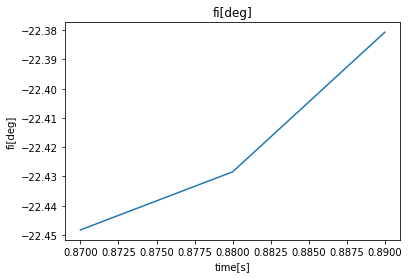

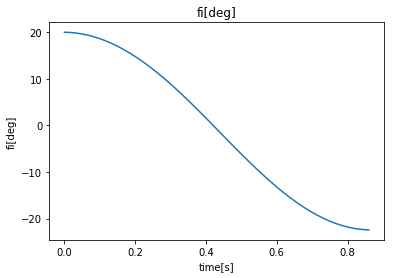

In [138]:
r = Record()
r.position_set(20)
r.PID_control(how_many_iter=30 , Kp=500)
r.visualize(['fi'], r.last_movement)
r.visualize(['fi'], r.stack_of_movement)

In [128]:
r.last_movement

,__x,_x,x,__fi,_fi,fi,t
0,-1.450906,-0.173314,-0.011310,2.120662,0.245304,0.364801,0.12
1,-1.480037,-0.188114,-0.013192,2.117206,0.266476,0.367466,0.13
2,-1.480881,-0.202923,-0.015221,2.142238,0.287899,0.370345,0.14


53.50816905515288


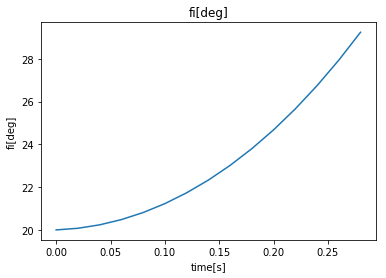

In [132]:
r = Record()
r.position_set(20)
r.move([(0, 0.3)])
r.visualize(['fi'], r.last_movement)
print(r.PID_single_move(100, 0.05, 0))

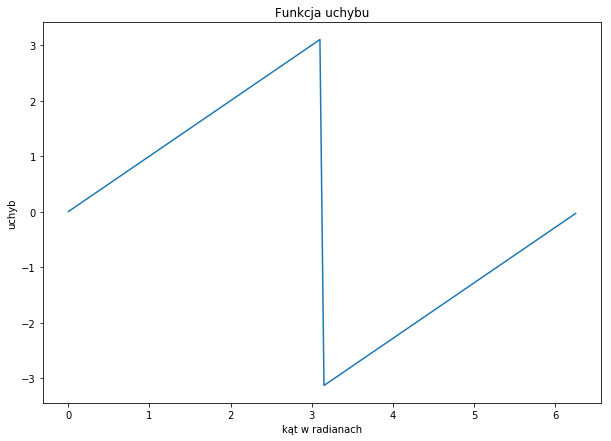

In [106]:
plt.figure(figsize=(10, 7))
res = []
for alfa in np.arange(0, np.pi*2, 0.05):
    e1 = np.abs(0  - alfa)
    e2 = np.abs(2*np.pi - alfa)
    if e1 < e2:
        e = e1
    else:
        e = -e2
    #plt.scatter(alfa, e)
    res.append((alfa, e))
a = np.array(res)
plt.plot(a[:, 0], a[:, 1])
plt.xlabel("kąt w radianach")
plt.ylabel("uchyb")
plt.title("Funkcja uchybu")
plt.savefig("error_function.png")
plt.show()